In [14]:
import pandas as pd
import numpy as np
import os
import datetime
from io import StringIO

In [15]:
def get_dataFrame(path, filename, truncate_p=0):
    
    with open(path) as f:
        lines = f.readlines()
    
    units = lines[2] # Line containing [sec][hPa][°C][%][m/s][°] etc
    csv_string = StringIO(''.join([lines[1]] + lines[3:])) # Get rid of initial "Profile Data" Line and units units line e.g °C
    
    df = pd.read_csv(csv_string, sep='\t') # Read data as csv
    
    df.columns = [col.strip() for col in df.columns] # Remove whitespace in column names
    
    # Get rid of trailing lines beginning with "Tropopauses: "
    df.dropna(axis=0, inplace=True) # NOTE: Assumes no n/a values in column data
    df = df.astype(np.float64) # Change datatype of values from strings to floats

    # Truncate Pressures
    if truncate_p:
        df = df[df['P']>=truncate_p]
         
    # Name df by date
    date = filename[:8] # Assuming 8 letters beginning filename are date (regex in following line unnecessary)
    # re.search(r'2020[\d]{4}',path).group() 
    
    d = datetime.datetime.strptime(date, '%Y%m%d')
    date_formatted = d.strftime('%m/%d/%Y')
    
    df.name = date_formatted
    
    return df

In [16]:
df_list = []
PATH = 'NepalData/' # Change to current data directory
for root, dirs, files in os.walk(PATH):
    for name in files:
        file_path = os.path.join(root,name)
        df_list.append(get_dataFrame(file_path,filename=name,truncate_p=0))
        print(file_path)
    
    for dir_ in dirs:
        print(os.path.join(root,dir_))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 191: invalid start byte

In [11]:
def concatenate_dfs(df_list):
    dated_dfs = []
    for df in df_list.copy():
        df['Date'] = [df.name]*df.shape[0]
        df = df[[list(df)[-1]]+list(df)[:-1]] # Change Column order to have date first
        dated_dfs.append(df)

    return pd.concat(dated_dfs, axis=0, ignore_index=True)

In [12]:
df_concat = concatenate_dfs(df_list)
df_concat

,Date,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Geopot,Dewp.
0,01/01/2020,0.0,876.0,1.5,100.0,0.9,202.0,85.289636,27.681809,1311.0,1.5
1,01/01/2020,1.0,875.2,1.9,99.0,0.9,200.0,85.289635,27.681814,1318.0,1.7
2,01/01/2020,2.0,874.5,2.3,97.0,0.9,197.0,85.289634,27.681818,1325.0,1.9
3,01/01/2020,3.0,873.7,2.7,96.0,0.9,195.0,85.289633,27.681823,1332.0,2.0
4,01/01/2020,4.0,873.0,3.1,94.0,0.9,192.0,85.289632,27.681828,1339.0,2.2
...,...,...,...,...,...,...,...,...,...,...,...
16418,01/07/2020,3029.0,38.5,-58.6,1.0,4.4,325.0,86.205206,27.565901,22185.0,-88.0
16419,01/07/2020,3030.0,38.4,-58.6,1.0,4.5,326.0,86.205222,27.565870,22192.0,-88.1
16420,01/07/2020,3031.0,38.4,-58.6,1.0,4.4,328.0,86.205238,27.565840,22199.0,-88.1
16421,01/07/2020,3032.0,38.3,-58.6,1.0,4.3,330.0,86.205255,27.565809,22205.0,-88.2


Date       object
Time      float64
P         float64
T         float64
Hu        float64
Ws        float64
Wd        float64
Long.     float64
Lat.      float64
Geopot    float64
Dewp.     float64
dtype: object

In [220]:
df_concat.to_csv('concatData.csv')

# EDA

In [231]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')

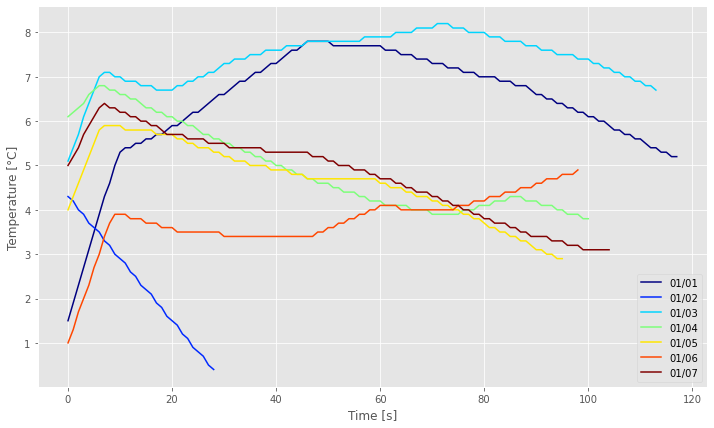

In [214]:
plt.figure(figsize=(12,7))
colors = plt.cm.jet(np.linspace(0,1,len(df_list)))
for i,df in enumerate(df_list):
    plt.plot(df['Time'],df['T'], label=df.name[:-5], color=colors[i])
    
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.show()

In [227]:
df_concat[df_concat['Time']==0]

,Date,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Geopot,Dewp.
0,01/01/2020,0.0,876.0,1.5,100.0,0.9,202.0,85.289636,27.681809,1311.0,1.5
2209,01/02/2020,0.0,876.4,4.3,100.0,0.4,333.0,85.289622,27.681836,1311.0,4.3
2452,01/03/2020,0.0,873.5,5.1,100.0,0.3,132.0,85.289643,27.681813,1311.0,5.1
5391,01/04/2020,0.0,870.6,6.1,100.0,0.4,211.0,85.289642,27.681809,1311.0,6.1
8189,01/05/2020,0.0,868.2,4.0,100.0,0.0,0.0,85.289631,27.681807,1311.0,4.0
10648,01/06/2020,0.0,870.1,1.0,100.0,0.5,120.0,85.289630,27.681797,1311.0,1.0
13389,01/07/2020,0.0,870.8,5.0,100.0,0.6,287.0,85.289641,27.681798,1311.0,5.0


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

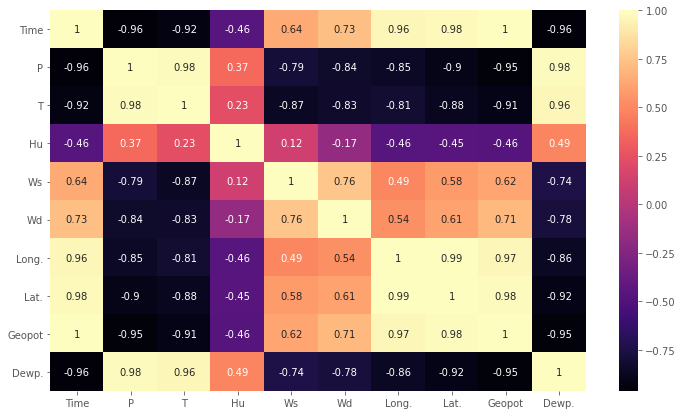

In [249]:
plt.figure(figsize=(12,7))
sns.heatmap(df_list[0].corr(), center=0, cmap='magma',annot=True)
plt.yticks(rotation=0)

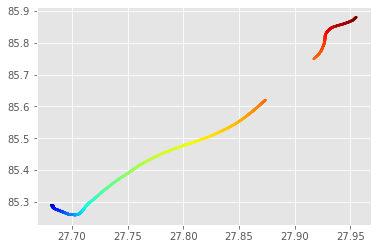

In [244]:
df = df_list[0]
colors = plt.cm.jet(np.linspace(0,1,df.shape[0]))
plt.scatter(df['Lat.'], df['Long.'], c=colors, s=4)
plt.show()

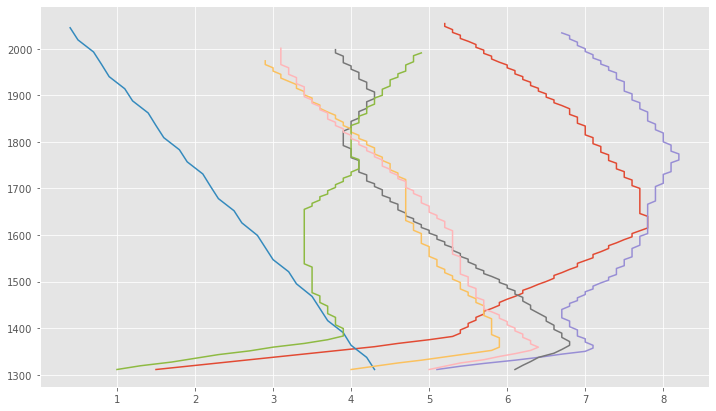

In [250]:
plt.figure(figsize=(12,7))
for df in df_list:
    cur_df = df[df['P']>=800]
    plt.plot(cur_df['T'],cur_df['Geopot'])

In [251]:
df_list[0]

,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Geopot,Dewp.,Date
0,0.0,876.0,1.5,100.0,0.9,202.0,85.289636,27.681809,1311.0,1.5,01/01/2020
1,1.0,875.2,1.9,99.0,0.9,200.0,85.289635,27.681814,1318.0,1.7,01/01/2020
2,2.0,874.5,2.3,97.0,0.9,197.0,85.289634,27.681818,1325.0,1.9,01/01/2020
3,3.0,873.7,2.7,96.0,0.9,195.0,85.289633,27.681823,1332.0,2.0,01/01/2020
4,4.0,873.0,3.1,94.0,0.9,192.0,85.289632,27.681828,1339.0,2.2,01/01/2020
...,...,...,...,...,...,...,...,...,...,...,...
2204,2587.0,51.1,-60.6,8.0,28.9,252.0,85.878949,27.954940,20471.0,-77.5,01/01/2020
2205,2588.0,51.1,-60.6,9.0,29.0,252.0,85.879222,27.955022,20479.0,-77.1,01/01/2020
2206,2589.0,51.0,-60.5,9.0,29.2,253.0,85.879494,27.955104,20486.0,-76.8,01/01/2020
2207,2590.0,50.9,-60.5,10.0,29.3,253.0,85.879767,27.955185,20494.0,-76.4,01/01/2020
